In [57]:
# Este comando descarga el repositorio entero a una carpeta llamada 'TFMDS' en Colab.
#!git clone https://github.com/jmorala/TFMDS.git

# Inicializar directorios
Clonar repositorio github
Posicionarse en el directorio raíz

In [58]:
import os

# Detectar si estamos en Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Configurar el directorio de trabajo según el entorno
if IN_COLAB:
    os.chdir('TFMDS')
else:
    # En VS Code local, nos movemos al directorio raíz del proyecto
    # Usa raw string para evitar errores de escape en rutas Windows
    current_dir = r'C:\Users\jmora\Documents\TFMDS'
    os.chdir(current_dir)

# OPCIONAL: Para verificar que estás en la ruta correcta y ver las carpetas
print("Directorio de trabajo actual:", os.getcwd())

Directorio de trabajo actual: C:\Users\jmora\Documents\TFMDS


## Lectura de fichero y adaptación de los tipos


In [59]:
import pandas as pd

# Ruta relativa del archivo CSV
RUTA_DATOS = 'datos/STDatosVentasTienda.csv'

# Cargar el archivo en un DataFrame de Pandas
dfSTventas = pd.read_csv(RUTA_DATOS, sep=';',
    parse_dates=['idSecuencia'])

# Convertir la columna anio_mes a período mensual
dfSTventas['anio_mes'] = pd.to_datetime(dfSTventas['anio_mes']).dt.to_period('M')

# Muestra las primeras filas y la información de las columnas para iniciar la exploración
print("Primeras filas del DataFrame:")
print(dfSTventas.head())

print("\nInformación de las columnas y tipos de datos:")
dfSTventas.info()

Primeras filas del DataFrame:
  idSecuencia  producto  udsVenta  bolPromocion  bolOpen  bolHoliday  \
0  2022-11-06         1         0             1        0           1   
1  2022-11-07         1        12             1        1           0   
2  2022-11-08         1        28             1        1           0   
3  2022-11-09         1        14             1        1           0   
4  2022-11-10         1        26             1        1           0   

   udsStock  rotura_stock anio_mes  
0       148         False  2022-11  
1       148         False  2022-11  
2       136         False  2022-11  
3       306         False  2022-11  
4       291         False  2022-11  

Información de las columnas y tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653514 entries, 0 to 653513
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   idSecuencia   653514 non-null  datetime64[ns]
 1   

# Cluster de productos según volumen de ventas

In [60]:
# Número de productos únicos
dfSTventasPorProducto = (dfSTventas.groupby('producto').agg({'udsVenta': 'sum'}).sort_values('udsVenta', ascending=False).reset_index())
# describe dfSTventasPorProducto
print("\nDescripción de unidades vendidas por producto:")
print(dfSTventasPorProducto.udsVenta.describe())


Descripción de unidades vendidas por producto:
count     894.000000
mean     1078.806488
std       760.800367
min       104.000000
25%       593.000000
50%       871.500000
75%      1334.000000
max      6398.000000
Name: udsVenta, dtype: float64



Productos agrupados por clusters según sus ventas totales:
     producto  udsVenta  Cluster
318       290      1054        0
317       462      1056        0
316       425      1057        0
315       669      1057        0
314       172      1057        0
..        ...       ...      ...
434       309       889        3
433       547       889        3
432       995       891        3
431       867       891        3
430       796       891        3

[894 rows x 3 columns]

Número de productos por cluster:
Cluster
3    464
0    303
1    107
2     20
Name: count, dtype: int64

Ventas totales por cluster:
Cluster
0    368275
1    246600
2     79809
3    269769
Name: udsVenta, dtype: int64


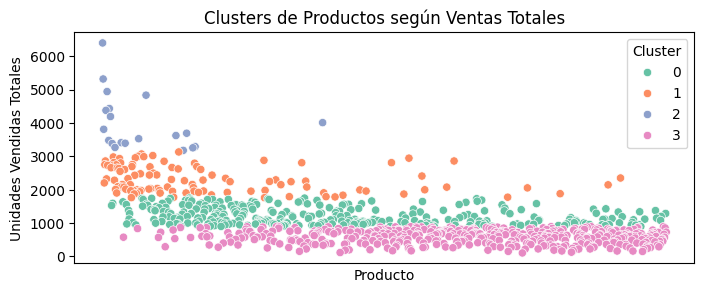

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear N clusters de productos según sus ventas totales
from sklearn.cluster import KMeans
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(dfSTventasPorProducto[['udsVenta']])
dfSTventasPorProducto['Cluster'] = kmeans.labels_
print("\nProductos agrupados por clusters según sus ventas totales:")
print(dfSTventasPorProducto.sort_values('Cluster'))

# mostrar cuantos productos tiene cada cluster
print("\nNúmero de productos por cluster:")
print(dfSTventasPorProducto['Cluster'].value_counts())

# mostrar cuantas ventas totales tiene cada cluster
print("\nVentas totales por cluster:")
print(dfSTventasPorProducto.groupby('Cluster')['udsVenta'].sum())

# Mostrar gráfico de los clusters
plt.figure(figsize=(8, 3))
sns.scatterplot(data=dfSTventasPorProducto, x='producto', y='udsVenta', hue='Cluster', palette='Set2', legend='full')
plt.title('Clusters de Productos según Ventas Totales')
plt.xticks([])
plt.xlabel('Producto')
plt.ylabel('Unidades Vendidas Totales')
plt.legend(title='Cluster')
plt.show()

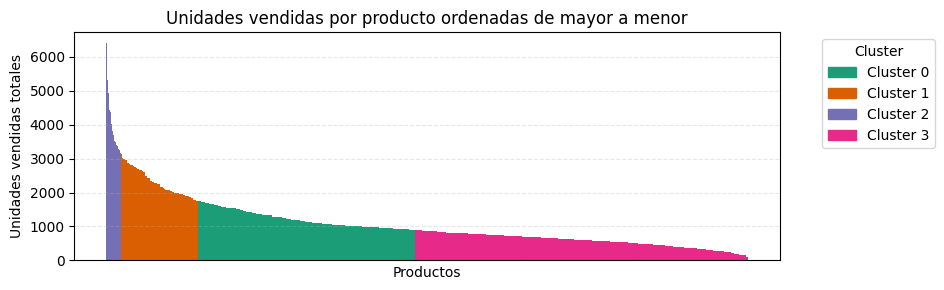

In [62]:
# Paleta de colores para los 4 clusters

cluster_colors = {
    0: '#1b9e77',  # verde azulado
    1: '#d95f02',  # naranja
    2: '#7570b3',  # azul
    3: '#e7298a'   # rosa
}


# Asignamos colores según el cluster
colors = dfSTventasPorProducto['Cluster'].map(cluster_colors)

plt.figure(figsize=(8, 3))
plt.bar(range(len(dfSTventasPorProducto)),
        dfSTventasPorProducto['udsVenta'],
        width=1.0,
        color=colors,
        edgecolor='none')

plt.title('Unidades vendidas por producto ordenadas de mayor a menor', fontsize=12)
plt.xlabel('Productos')
plt.ylabel('Unidades vendidas totales')
plt.xticks([])
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# Leyenda para los clusters
handles = [plt.Rectangle((0,0),1,1, color=cluster_colors[c]) for c in cluster_colors]
plt.legend(handles, [f'Cluster {c}' for c in cluster_colors], title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [63]:
# Asignar los clusters al DataFrame original
dfSTventas = dfSTventas.merge(dfSTventasPorProducto[['producto', 'Cluster']], on='producto', how='left')
print("\nDataFrame original con clusters asignados:")
print(dfSTventas.head()[['idSecuencia','producto', 'udsVenta', 'Cluster']])


DataFrame original con clusters asignados:
  idSecuencia  producto  udsVenta  Cluster
0  2022-11-06         1         0        2
1  2022-11-07         1        12        2
2  2022-11-08         1        28        2
3  2022-11-09         1        14        2
4  2022-11-10         1        26        2


In [64]:
# Crear dataframe por cluster idSecuencia y suma de udsVenta
dfSTventasPorCluster = (dfSTventas.groupby(['idSecuencia', 'Cluster'])
                        .agg({'udsVenta': 'sum', 'bolOpen': 'max'})
                        .reset_index())
print("\nDataFrame de ventas por idSecuencia y Cluster:")
print(dfSTventasPorCluster.head())



DataFrame de ventas por idSecuencia y Cluster:
  idSecuencia  Cluster  udsVenta  bolOpen
0  2022-11-06        0        48        0
1  2022-11-06        1        29        0
2  2022-11-06        2        23        0
3  2022-11-06        3        37        0
4  2022-11-07        0       687        1


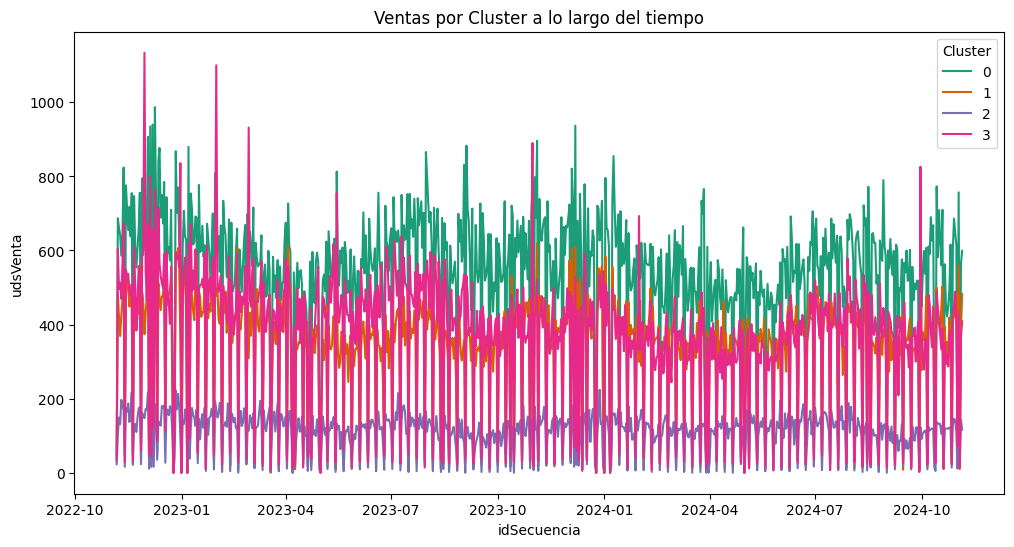

In [65]:
# Mostrar gráfico de ventas por cluster a lo largo del tiempo
plt.figure(figsize=(12, 6))
sns.lineplot(data=dfSTventasPorCluster, x='idSecuencia', y='udsVenta', hue='Cluster', palette=cluster_colors)
plt.title('Ventas por Cluster a lo largo del tiempo')
plt.show()


# Incluir características de calendario
- Día de la semana
- Mes
- Trimestre
- Si es fin de semana (!Pensar si vale la pena, ya que se sabe por día semana)

In [66]:
# Incluir en dfSTventas nuevas columnas de características temporales
dfSTventas['dia_semana'] = dfSTventas['idSecuencia'].dt.dayofweek
dfSTventas['mes'] = dfSTventas['idSecuencia'].dt.month
dfSTventas['trimestre'] = dfSTventas['idSecuencia'].dt.quarter
dfSTventas['fin_de_semana'] = dfSTventas['dia_semana'].isin([5, 6]).astype(int)
print("\nDataFrame con nuevas características temporales:")
print(dfSTventas.head())


DataFrame con nuevas características temporales:
  idSecuencia  producto  udsVenta  bolPromocion  bolOpen  bolHoliday  \
0  2022-11-06         1         0             1        0           1   
1  2022-11-07         1        12             1        1           0   
2  2022-11-08         1        28             1        1           0   
3  2022-11-09         1        14             1        1           0   
4  2022-11-10         1        26             1        1           0   

   udsStock  rotura_stock anio_mes  Cluster  dia_semana  mes  trimestre  \
0       148         False  2022-11        2           6   11          4   
1       148         False  2022-11        2           0   11          4   
2       136         False  2022-11        2           1   11          4   
3       306         False  2022-11        2           2   11          4   
4       291         False  2022-11        2           3   11          4   

   fin_de_semana  
0              1  
1              0  
2        

# Time elapsed
- Se puede poner el número del día desde el inicio de la serie?

# Incluir Lags
- Para los siete días anteriores (incluyendo el mismo día de la semana anterior)
- Sería bueno el mismo día de la misma semana del año pasado, pero se elimina un año entero de datos
- Hay que tener en cuenta el producto

# Rolling window aggregations
Posibles
- Media, máximo, mínimo, desviación estándard de ventas del mes pasado o mismo mes año pasado (si no hay datos qué hacer?) para el mismo producto
- Lo mismo para ventas totales de los productos del mismo cluster?
- Lo mismo para ventas totales de todos los producto=?
- alternativas varios valores seguidos, se pued poner varios y solapados (ver Figura6.3 Capítulo 6 Modern Time Series)- 

# Seasonal rolling window aggregations

# Exponentially weighted moving average (EWMA)

# Salvar fichero

In [67]:
# Guradar el DataFrame preprocesado a un nuevo archivo CSV quitando anio_mes
dfSTventas.drop(columns=['anio_mes','rotura_stock', 'udsStock'], inplace=True)
dfSTventas.to_csv('datos/STDatosVentasTiendaWIP.csv', sep=';', index=False)
print("\nDataFrame preprocesado guardado en 'datos/STDatosVentasTiendaWIP.csv'")


DataFrame preprocesado guardado en 'datos/STDatosVentasTiendaWIP.csv'
